In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
from sys import modules

warnings.filterwarnings('ignore')
%matplotlib inline

# Rare classes

In many real-world problems some of the classes are much more rare than others, and very often this is the situation with the classes we are actually interested in (e.g. fraud detection and churn prediction). To understand how to deal with this situation let's create an imbalanced version of the _radar_ dataset by sampling the planes.

In [0]:
if 'google.colab' in modules:
    from google.colab import files
    uploaded = files.upload()

In [0]:
radar = pd.read_csv("radar.csv", index_col=0)
planes = radar.ix[radar.Type=='Plane', :]
birds = radar.ix[radar.Type=='Bird', :]
radar_imbalanced = pd.concat((planes[::10], birds), axis=0)
radar_imbalanced.reset_index(drop=True, inplace=True)

In [0]:
radar_imbalanced.Type.value_counts()

Bird     1355
Plane     122
Name: Type, dtype: int64

We now apply a very simple classification model called logistic regression. 

In [0]:
X = radar_imbalanced[['Size']]
y = radar_imbalanced['Type']

clf = LogisticRegression().fit(X, y)

Let's assess the model performance.

In [0]:
acc = accuracy_score(y_true=y, 
                     y_pred=clf.predict(X))
cm = pd.DataFrame(confusion_matrix(y_true=y, 
                                   y_pred=clf.predict(X)), 
                  index=clf.classes_, 
                  columns=clf.classes_)
rep = classification_report(y_true=y, 
                            y_pred=clf.predict(X))
print 'Accuracy: {}\n\n{}\n\n{}'.format(acc, cm, rep)

Accuracy: 0.973595125254

       Bird  Plane
Bird   1355      0
Plane    39     83

             precision    recall  f1-score   support

       Bird       0.97      1.00      0.99      1355
      Plane       1.00      0.68      0.81       122

avg / total       0.97      0.97      0.97      1477



A common problem is that the naive classifiers will inevitably have some bias due to the imbalance of the data. The symmetrical measures (e.g. accuracy) and those of the majority class ('Bird') look reasonable, but this is misleading. The minority class has a negligible effect, and actually the performance of naive classifiers when the data is not balanced is very close to the performance of the "always-say-yes" classifier. While the majority class gets all the attention, the performance of the minority class is very bad, as it is "swamped" by the majority class.

There are several methods of dealing with this situation, each working in a different step of the analysis:

* **under/over sampling** - using a subset/copies of the common/rare classes, so that the data is more balanced.
* **Penalizing** - giving a higher weight to mistakes in classifying rare classes during the fitting process.
* **imbalanced measures** - using measures that reflect the data imbalance (highly related to the next topic).

# Business trade-offs between classes

Very often the classes do not have equal "importances", and consequntly we are more interested in increasing their measures (sensitivity,  precision, etc.). It is easier to think of the model as classifying "balanced" classes, and then to trade-off between the classes by applying the "right" threshold on their probabilities. We will see one of two common curves that do exactly that - the ROC curve.

For the sake of this section we look again on the "balanced" _radar_ dataset.

In [0]:
radar = pd.read_csv("radar.csv", index_col=0)

X = radar[['Size']]
y = radar['Type']

In [0]:
clf = LogisticRegression().fit(X, y)

## The ROC curve

The trade-off between sensitivity and specificity for binary classification models is usually illustrated by a simple graph called [Receiver Operating Characteristic (ROC) curve][roc], in which the TPR (sensitivity) is drawn versus the FPR ($=1-Specificity$). Ideally there is a point in which TPR=1 and FPR=0, but in reality this never happens, and the ROC assists in making the business decision concerning the threshold for classification. 

[roc]: https://en.wikipedia.org/wiki/Receiver_operating_characteristic "ROC curve - Wikipedia"

### Explaining the _roc_\__curve()_ function

The ROC is implemented by the [_roc_\__curve()_][roc_curve] function from the _metrics_ module, but it is not an intuitive function, so we first explain how it works. Let's assume that the classifier had already been fitted, and we can now have the prediction probabilities. The actual values are marked as _y_, and the probabilities of the positive label ('Plane') are called _scores_.

[roc_curve]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html "roc_curve() API"

> **NOTE:** The probabilities are called _scores_ because the ROC can be evaluated also for estimator outputs which are not probabilities (like for the logistic regression).

In [0]:
y = np.array(['Bird', 'Bird', 'Bird', 'Bird', 'Plane', 'Plane'])
scores = np.array([0.2, 0.1, 0.4, 0.6, 0.9, 0.5])

In [0]:
fpr, tpr, thresholds = roc_curve(y, scores, pos_label='Plane')
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
res[['TPR', 'FPR', 'Threshold']]

,TPR,FPR,Threshold
0,0.5,0.00,0.9
1,0.5,0.25,0.6
2,1.0,0.25,0.5
3,1.0,1.00,0.1


For illustration, let's understand how row 1 is evaluated. The business decision is that if the positive probability is higher than or equal to 0.6, then we classify the object as a plane. Applying this rule means that only one of the two planes will be classified correctly as a plane (hence _TPR = 0.5_), but only one of the four birds will be classified erroneously as a plane (hence _FPR = 0.25_).

The FPR and the TPR are evaluated for every probability threshold, and the result is a graph of the trade-off between TPR and FPR. Thresholds with the same TPR/FPR are omitted. 

(0, 1)

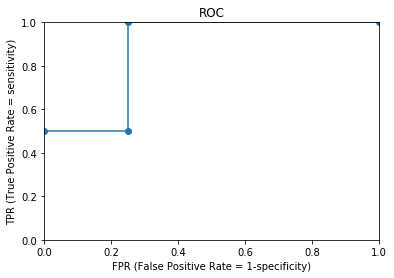

In [0]:
plt.plot(fpr, tpr, '-o')
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([0, 1])
plt.ylim([0, 1])

## Full demonstration

In [0]:
y = radar.Type
scores = clf.predict_proba(X)[:, 1]

In [0]:
fpr, tpr, thresholds = roc_curve(y, scores, pos_label='Plane')
res = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
res[['TPR', 'FPR', 'Threshold']][::100]

,TPR,FPR,Threshold
0,0.000824,0.000000,0.999999
100,0.256178,0.000000,0.994927
200,0.523888,0.000000,0.926611
300,0.767710,0.023616,0.566486
400,0.901977,0.485609,0.183803
500,0.977759,0.978598,0.034910


(0, 1)

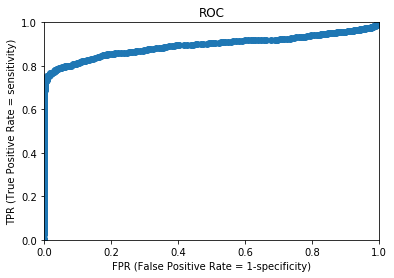

In [0]:
plt.plot(fpr, tpr, '-o')
plt.title('ROC')
plt.xlabel('FPR (False Positive Rate = 1-specificity)')
plt.ylabel('TPR (True Positive Rate = sensitivity)')
plt.xlim([0, 1])
plt.ylim([0, 1])

## The AUC

As a general indication of the classifier quality it is sometimmes useful to look at the area under the ROC curve (called AUC), which is implemented by the [_roc_\__aoc_\__score()_][auc] function. Unlike the _roc_\__curve()_ function, this function does not support the _pos_\__label_ argument, so the _y_ labels must be _0_ and _1_. The AUC ranges from 0.5 to 1, where 0.5 means the model is useless, since every threshold is equivalent to a random guess, and 1 means that there is a threshold yielding perfect separation between negative and positive classes.

[auc]: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html "roc_auc_score() API" 

In [0]:
roc_auc_score(y=='Plane', scores)

0.89425095898405438